In [1]:
# الخلية 1: استيراد المكتبات وتحميل البيانات مع نتائج النماذج

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # على الرغم من أننا قد لا نستخدمه مباشرة في هذه الخلية، من الجيد استيراده
import seaborn as sns # نفس الملاحظة
import os

# إعدادات العرض لـ Pandas (اختياري)
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 100)      
pd.set_option('display.width', 1000)       
pd.set_option('display.float_format', '{:.2f}'.format)

print("--- الخلية 1: بدء استيراد المكتبات وتحميل بيانات النتائج ---")
print("المكتبات الأساسية تم استيرادها.")

# --- تحديد مسارات الملفات ---
# نفترض أن دفتر الملاحظات هذا موجود في مجلد 'notebooks'
# والبيانات المعالجة موجودة في 'data/processed/' بالنسبة لجذر المشروع
project_root = os.path.abspath(os.path.join(os.getcwd(), '..')) 
processed_data_dir = os.path.join(project_root, 'data', 'processed') # <--- تم تعريفه هنا

path_kmeans_results = os.path.join(processed_data_dir, 'problems_with_kmeans_clusters.csv')
path_bertopic_results = os.path.join(processed_data_dir, 'problems_with_bertopic_topics.csv')

# الأعمدة التاريخية لتحليلها بشكل صحيح عند القراءة
date_columns_to_parse = ['date_identified', 'date_closed', 'date_chosen', 
                         'start_date_planned', 'end_date_planned', 
                         'start_date_actual', 'end_date_actual']

# --- تحميل البيانات مع نتائج K-Means ---
df_kmeans = pd.DataFrame() # تهيئة كـ DataFrame فارغ
try:
    df_kmeans = pd.read_csv(path_kmeans_results, parse_dates=date_columns_to_parse)
    print(f"تم تحميل '{path_kmeans_results}' بنجاح. الأبعاد: {df_kmeans.shape}")
except FileNotFoundError:
    print(f"خطأ: لم يتم العثور على ملف K-Means results في: {path_kmeans_results}")
except Exception as e:
    print(f"حدث خطأ آخر أثناء تحميل بيانات K-Means: {e}")

# --- تحميل البيانات مع نتائج BERTopic ---
df_bertopic = pd.DataFrame() # تهيئة كـ DataFrame فارغ
try:
    df_bertopic = pd.read_csv(path_bertopic_results, parse_dates=date_columns_to_parse)
    print(f"تم تحميل '{path_bertopic_results}' بنجاح. الأبعاد: {df_bertopic.shape}")
except FileNotFoundError:
    print(f"خطأ: لم يتم العثور على ملف BERTopic results في: {path_bertopic_results}")
except Exception as e:
    print(f"حدث خطأ آخر أثناء تحميل بيانات BERTopic: {e}")

# --- دمج نتائج النماذج في DataFrame واحد ---
df_final_results = pd.DataFrame() # نهيئه كـ DataFrame فارغ مبدئيًا

if not df_kmeans.empty:
    df_final_results = df_kmeans.copy() # نبدأ بنسخة من بيانات K-Means
    
    if not df_bertopic.empty and 'bertopic_topic' in df_bertopic.columns and 'problem_id' in df_bertopic.columns:
        # دمج بناءً على problem_id للتأكد من محاذاة الصفوف بشكل صحيح
        # اختر فقط الأعمدة المطلوبة من df_bertopic لتجنب تكرار الأعمدة الأخرى
        # ولتجنب مشاكل الـ suffixes إذا كانت هناك أعمدة مشتركة أخرى غير problem_id
        df_final_results = pd.merge(df_final_results, 
                                    df_bertopic[['problem_id', 'bertopic_topic']].copy(), # اعمل على نسخة لتجنب تعديل df_bertopic الأصلي
                                    on='problem_id', 
                                    how='left') # left join للحفاظ على جميع الصفوف من df_kmeans
        print("تم دمج عمود 'bertopic_topic' بنجاح باستخدام 'problem_id'.")
    elif not df_bertopic.empty and 'bertopic_topic' in df_bertopic.columns:
        # إذا لم يكن problem_id موجودًا في df_bertopic للدمج، ولكن الفهرس قد يكون متطابقًا
        if len(df_final_results) == len(df_bertopic) and df_final_results.index.equals(df_bertopic.index):
            df_final_results['bertopic_topic'] = df_bertopic['bertopic_topic']
            print("تم إضافة عمود 'bertopic_topic' بناءً على تطابق الفهرس (افتراض أن الترتيب والفهرس محفوظان).")
        else:
            print("تحذير: لا يمكن دمج 'bertopic_topic' بشكل موثوق. قد يكون 'problem_id' مفقودًا من بيانات BERTopic أو هناك اختلاف في الفهرس/عدد الصفوف.")
            if 'bertopic_topic' not in df_final_results.columns:
                 df_final_results['bertopic_topic'] = np.nan # أضفه كـ NaN إذا لم يتم الدمج
    else:
        print("لم يتم العثور على عمود 'bertopic_topic' في بيانات BERTopic أو أن بيانات BERTopic فارغة. سيتم إضافة عمود bertopic_topic فارغ.")
        if 'bertopic_topic' not in df_final_results.columns: 
             df_final_results['bertopic_topic'] = np.nan 

    if not df_final_results.empty:
        print("\n--- DataFrame النهائي مع نتائج النماذج (df_final_results) ---")
        print(f"الأبعاد: {df_final_results.shape}")
        print("عينة من الأعمدة الرئيسية:")
        cols_to_display = ['problem_id', 'title', 'processed_text', 'cluster_kmeans', 'bertopic_topic']
        existing_cols_to_display = [col for col in cols_to_display if col in df_final_results.columns]
        if existing_cols_to_display: # تحقق من وجود الأعمدة قبل العرض
            display(df_final_results[existing_cols_to_display].head(10))

        print("\nالتحقق من القيم المفقودة في أعمدة النتائج الجديدة:")
        if 'cluster_kmeans' in df_final_results.columns:
            print(f"NaNs في cluster_kmeans: {df_final_results['cluster_kmeans'].isnull().sum()}")
        if 'bertopic_topic' in df_final_results.columns:
            print(f"NaNs في bertopic_topic: {df_final_results['bertopic_topic'].isnull().sum()}")
        
        # --- حفظ DataFrame المدمج للاستخدام لاحقًا ---
        final_results_file_path = os.path.join(processed_data_dir, 'final_results_with_models.csv') # processed_data_dir معرف في الأعلى
        df_final_results.to_csv(final_results_file_path, index=False, encoding='utf-8-sig')
        print(f"تم حفظ df_final_results (البيانات المدمجة مع نتائج النماذج) في: {final_results_file_path}")
    else:
        print("لم يتم إنشاء df_final_results بشكل صحيح (قد يكون فارغًا)، لذا لن يتم حفظه.")

elif df_kmeans.empty: # إذا كان df_kmeans فارغًا من البداية
    print("لم يتم تحميل بيانات K-Means، لا يمكن المتابعة مع df_final_results ولن يتم حفظه.")
    # df_final_results سيكون DataFrame فارغًا بالفعل من التهيئة أعلاه

print("\n--- الخلية 1: اكتمل تحميل ودمج بيانات النتائج ---")

--- الخلية 1: بدء استيراد المكتبات وتحميل بيانات النتائج ---
المكتبات الأساسية تم استيرادها.
تم تحميل 'C:\Users\pc\PycharmProjects\pythonProject\problem_ai_advisor\data\processed\problems_with_kmeans_clusters.csv' بنجاح. الأبعاد: (8, 53)
تم تحميل 'C:\Users\pc\PycharmProjects\pythonProject\problem_ai_advisor\data\processed\problems_with_bertopic_topics.csv' بنجاح. الأبعاد: (8, 53)
تم دمج عمود 'bertopic_topic' بنجاح باستخدام 'problem_id'.

--- DataFrame النهائي مع نتائج النماذج (df_final_results) ---
الأبعاد: (8, 54)
عينة من الأعمدة الرئيسية:


,problem_id,title,processed_text,cluster_kmeans,bertopic_topic
0,1,حب من جهة واحدة,حب جهه واحده,0,0
1,3,انخفاض ملحوظ في تفاعل الطلاب مع منصة التعلم ال...,انخفاض ملحوظ تفاعل الطلاب منصه التعلم الالكترو...,2,1
2,4,مفاتيح السيارة ضاعت مني,مفاتيح السياره ضاعت مني ذهبت الي النادي بعدها ...,0,0
3,5,أختناق مروري,اختناق مروري,0,0
4,10,موبايل مكسور,موبايل مكسور جوالي نوع جالاكسي اشتريته شركه جا...,1,2
5,11,ماوس كومبيوتري لا يشتغل,ماوس كومبيوتري يشتغل الماوس تمريره الي الامام ...,1,1
6,12,نقص هواء في الإطار الأمامي الأيسر للسيارة,نقص هواء الاطار الامامي الايسر للسياره لاحظت ا...,4,-1
7,13,جهاز الموبايل مسروق,جهاز الموبايل مسروق اتغديت بالمطعم لاحظت عدم و...,3,2



التحقق من القيم المفقودة في أعمدة النتائج الجديدة:
NaNs في cluster_kmeans: 0
NaNs في bertopic_topic: 0
تم حفظ df_final_results (البيانات المدمجة مع نتائج النماذج) في: C:\Users\pc\PycharmProjects\pythonProject\problem_ai_advisor\data\processed\final_results_with_models.csv

--- الخلية 1: اكتمل تحميل ودمج بيانات النتائج ---



--- الخلية 2: نظرة عامة على توزيعات العناقيد والموضوعات ---

--- توزيع المشاكل حسب عناقيد K-Means ---
cluster_kmeans
0    3
1    2
2    1
3    1
4    1
Name: count, dtype: int64


C:\Users\pc\AppData\Local\Temp\ipykernel_25528\2550106069.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=kmeans_distribution.index, y=kmeans_distribution.values, palette="viridis")


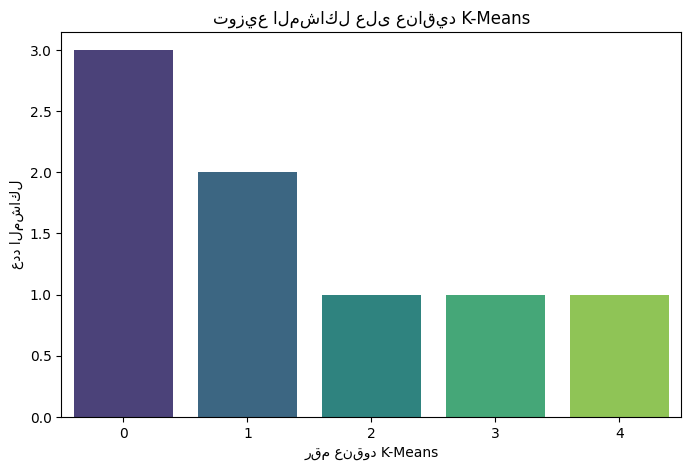


--- توزيع المشاكل حسب موضوعات BERTopic ---
bertopic_topic
-1    1
 0    3
 1    2
 2    2
Name: count, dtype: int64


C:\Users\pc\AppData\Local\Temp\ipykernel_25528\2550106069.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bertopic_distribution.index.astype(str), y=bertopic_distribution.values, palette="plasma") # تحويل الفهرس إلى str للعرض


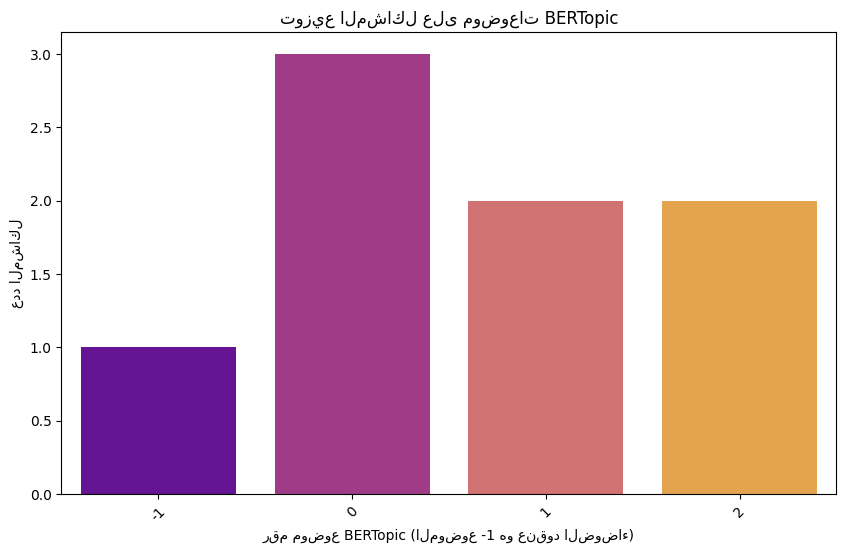


--- الخلية 2: اكتمل عرض التوزيعات ---


In [3]:
# الخلية 2: نظرة عامة على توزيعات العناقيد والموضوعات

if 'df_final_results' in locals() and not df_final_results.empty:
    print(f"\n--- الخلية 2: نظرة عامة على توزيعات العناقيد والموضوعات ---")

    # --- 1. توزيع عناقيد K-Means ---
    if 'cluster_kmeans' in df_final_results.columns:
        print("\n--- توزيع المشاكل حسب عناقيد K-Means ---")
        kmeans_distribution = df_final_results['cluster_kmeans'].value_counts().sort_index()
        print(kmeans_distribution)
        
        if not kmeans_distribution.empty:
            plt.figure(figsize=(8, 5))
            sns.barplot(x=kmeans_distribution.index, y=kmeans_distribution.values, palette="viridis")
            plt.title('توزيع المشاكل على عناقيد K-Means')
            plt.xlabel('رقم عنقود K-Means')
            plt.ylabel('عدد المشاكل')
            plt.show()
    else:
        print("عمود 'cluster_kmeans' غير موجود.")

    # --- 2. توزيع موضوعات BERTopic ---
    if 'bertopic_topic' in df_final_results.columns:
        print("\n--- توزيع المشاكل حسب موضوعات BERTopic ---")
        # تأكد من تحويل عمود الموضوعات إلى نوع يمكن التعامل معه (مثل int أو str إذا كان مختلطًا)
        # BERTopic قد يُرجع -1 كـ int، وباقي الموضوعات كـ int.
        # value_counts يتعامل مع هذا جيدًا.
        bertopic_distribution = df_final_results['bertopic_topic'].value_counts().sort_index()
        print(bertopic_distribution)
        
        if not bertopic_distribution.empty:
            plt.figure(figsize=(10, 6)) # قد يكون هناك المزيد من الموضوعات أو عنقود الضوضاء -1
            sns.barplot(x=bertopic_distribution.index.astype(str), y=bertopic_distribution.values, palette="plasma") # تحويل الفهرس إلى str للعرض
            plt.title('توزيع المشاكل على موضوعات BERTopic')
            plt.xlabel('رقم موضوع BERTopic (الموضوع -1 هو عنقود الضوضاء)')
            plt.ylabel('عدد المشاكل')
            plt.xticks(rotation=45)
            plt.show()
    else:
        print("عمود 'bertopic_topic' غير موجود.")
        
    print(f"\n--- الخلية 2: اكتمل عرض التوزيعات ---")
else:
    print("DataFrame 'df_final_results' غير متاح أو فارغ. يرجى تشغيل الخلية السابقة أولاً.")


--- الخلية 3: تحليل التقاطع بين K-Means و BERTopic ---

جدول التقاطع بين عناقيد K-Means وموضوعات BERTopic:


BERTopic Topic,-1,0,1,2
K-Means Cluster,,,,
0,0,3,0,0
1,0,0,1,1
2,0,0,1,0
3,0,0,0,1
4,1,0,0,0


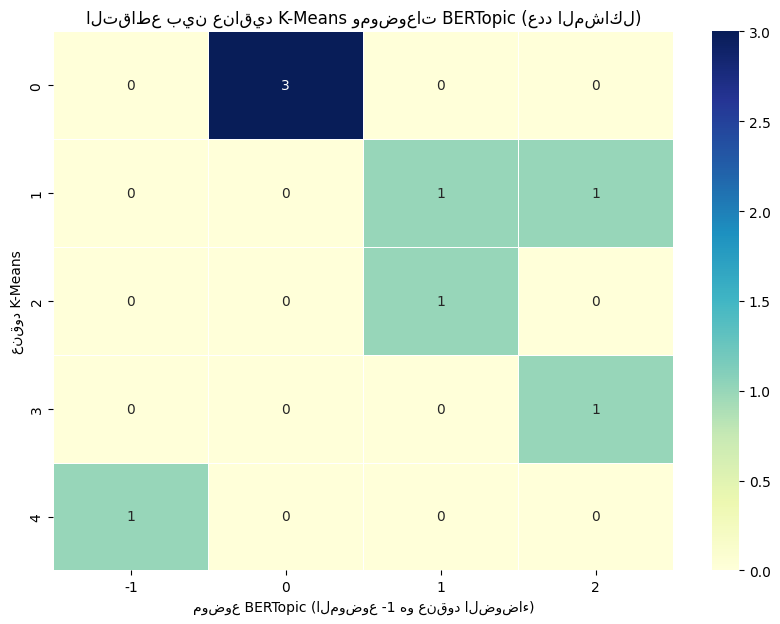


--- المشاكل الموجودة في عنقود K-Means (0) وموضوع BERTopic (0) ---


,problem_id,title,processed_text
0,1,حب من جهة واحدة,حب جهه واحده
2,4,مفاتيح السيارة ضاعت مني,مفاتيح السياره ضاعت مني ذهبت الي النادي بعدها ...
3,5,أختناق مروري,اختناق مروري



--- الخلية 3: اكتمل تحليل التقاطع ---


In [4]:
# الخلية 3: تحليل التقاطع بين عناقيد K-Means وموضوعات BERTopic

if 'df_final_results' in locals() and not df_final_results.empty:
    if 'cluster_kmeans' in df_final_results.columns and 'bertopic_topic' in df_final_results.columns:
        print(f"\n--- الخلية 3: تحليل التقاطع بين K-Means و BERTopic ---")

        # --- 1. إنشاء جدول تقاطعي (Crosstabulation) ---
        # يوضح عدد المشاكل لكل مزيج من عنقود K-Means وموضوع BERTopic
        crosstab_results = pd.crosstab(df_final_results['cluster_kmeans'], 
                                       df_final_results['bertopic_topic'],
                                       rownames=['K-Means Cluster'], 
                                       colnames=['BERTopic Topic'])
        
        print("\nجدول التقاطع بين عناقيد K-Means وموضوعات BERTopic:")
        display(crosstab_results)

        # --- 2. رسم خريطة حرارية (Heatmap) للجدول التقاطعي ---
        if not crosstab_results.empty:
            plt.figure(figsize=(10, 7))
            sns.heatmap(crosstab_results, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5)
            # fmt="d" لعرض الأرقام كأعداد صحيحة
            # cmap: لوحة الألوان
            plt.title('التقاطع بين عناقيد K-Means وموضوعات BERTopic (عدد المشاكل)')
            plt.ylabel('عنقود K-Means')
            plt.xlabel('موضوع BERTopic (الموضوع -1 هو عنقود الضوضاء)')
            plt.show()
        else:
            print("لا يمكن إنشاء خريطة حرارية لأن الجدول التقاطعي فارغ.")
            
        # --- 3. (اختياري) تحليل تفصيلي للمشاكل في تقاطعات معينة ---
        # مثال: عرض المشاكل التي تقع في عنقود K-Means رقم 0 وموضوع BERTopic رقم 0
        # يمكنك تكرار هذا لأي تقاطع يثير اهتمامك
        
        # افتراض أن لدينا عنقود K-Means 0 وموضوع BERTopic 0
        target_kmeans_cluster = 0
        target_bertopic_topic = 0 # أو أي موضوع آخر اكتشفه BERTopic
        
        # تأكد أن القيم موجودة في الأعمدة قبل التصفية
        if target_kmeans_cluster in df_final_results['cluster_kmeans'].unique() and \
           target_bertopic_topic in df_final_results['bertopic_topic'].unique():
            
            intersecting_problems = df_final_results[
                (df_final_results['cluster_kmeans'] == target_kmeans_cluster) &
                (df_final_results['bertopic_topic'] == target_bertopic_topic)
            ]

            print(f"\n--- المشاكل الموجودة في عنقود K-Means ({target_kmeans_cluster}) وموضوع BERTopic ({target_bertopic_topic}) ---")
            if not intersecting_problems.empty:
                cols_to_show_intersection = ['problem_id', 'title', 'processed_text']
                display(intersecting_problems[cols_to_show_intersection])
            else:
                print(f"لا توجد مشاكل مشتركة بين عنقود K-Means {target_kmeans_cluster} وموضوع BERTopic {target_bertopic_topic}.")
        else:
            print(f"أحد التصنيفات المستهدفة (K-Means {target_kmeans_cluster} أو BERTopic {target_bertopic_topic}) غير موجود في البيانات.")

        print(f"\n--- الخلية 3: اكتمل تحليل التقاطع ---")
    else:
        print("الأعمدة 'cluster_kmeans' أو 'bertopic_topic' غير موجودة في df_final_results.")
else:
    print("DataFrame 'df_final_results' غير متاح أو فارغ. يرجى تشغيل الخلية السابقة أولاً.")

In [5]:
# الخلية 4: إنشاء ملفات تعريفية (Profiles) للعناقيد والموضوعات

if 'df_final_results' in locals() and not df_final_results.empty:
    print(f"\n--- الخلية 4: إنشاء ملفات تعريفية للعناقيد والموضوعات ---")

    # --- 1. إنشاء ملفات تعريفية لعناقيد K-Means ---
    if 'cluster_kmeans' in df_final_results.columns:
        print("\n--- ملفات تعريفية لعناقيد K-Means ---")
        
        # الأعمدة الأصلية التي استخدمناها لتحليل خصائص العناقيد في دفتر 02
        original_numerical_to_analyze = ['estimated_cost_numeric', 'overall_budget_numeric', 
                                         'estimated_time_days', 'processed_text_length', 'sentiment_score']
        existing_original_numerical = [col for col in original_numerical_to_analyze if col in df_final_results.columns]

        original_categorical_to_analyze = ['domain', 'complexity_level', 'status', 'problem_source', 'sentiment_label']
        existing_original_categorical = [col for col in original_categorical_to_analyze if col in df_final_results.columns]

        kmeans_profiles = {}
        for cluster_id in sorted(df_final_results['cluster_kmeans'].unique()):
            profile = {}
            cluster_data = df_final_results[df_final_results['cluster_kmeans'] == cluster_id]
            
            profile['cluster_id'] = cluster_id
            profile['num_problems'] = len(cluster_data)
            profile['sample_titles'] = cluster_data['title'].head(3).tolist() # عينة من العناوين
            
            # متوسطات الميزات الرقمية (نستخدم القيم الأصلية قبل التحجيم للفهم)
            if existing_original_numerical:
                profile['avg_numerical_features'] = cluster_data[existing_original_numerical].mean().to_dict()
            
            # القيم الفئوية الشائعة
            if existing_original_categorical:
                profile['common_categorical_features'] = {}
                for col in existing_original_categorical:
                    mode_info = cluster_data[col].mode()
                    if not mode_info.empty:
                        profile['common_categorical_features'][col] = ", ".join(mode_info.tolist())
            
            # الكلمات الشائعة في النصوص المعالجة (نفس منطق الخلية 3 في دفتر 02)
            from collections import Counter # تأكد من استيرادها إذا لم تكن مستوردة في الأعلى
            cluster_texts = cluster_data['processed_text'].dropna().loc[cluster_data['processed_text'].str.strip() != '']
            if not cluster_texts.empty:
                full_cluster_text = " ".join(cluster_texts)
                words = full_cluster_text.split()
                if words:
                    profile['top_keywords_processed'] = [word for word, count in Counter(words).most_common(7)] # أكثر 7 كلمات
            
            kmeans_profiles[cluster_id] = profile
            
            # طباعة الملف التعريفي للعنقود الحالي
            print(f"\n**ملف تعريفي للعنقود K-Means رقم: {cluster_id}**")
            print(f"  عدد المشاكل: {profile['num_problems']}")
            print(f"  عناوين عينة: {profile['sample_titles']}")
            if 'avg_numerical_features' in profile:
                print("  متوسط الميزات الرقمية:")
                for k, v in profile['avg_numerical_features'].items():
                    print(f"    - {k}: {v:.2f}")
            if 'common_categorical_features' in profile:
                print("  القيم الفئوية الشائعة:")
                for k, v in profile['common_categorical_features'].items():
                    print(f"    - {k}: {v}")
            if 'top_keywords_processed' in profile:
                print(f"  أهم الكلمات المفتاحية (من النصوص المعالجة): {profile['top_keywords_processed']}")
                
    else:
        print("عمود 'cluster_kmeans' غير موجود لإنشاء ملفات تعريفية.")

    # --- 2. إنشاء ملفات تعريفية لموضوعات BERTopic ---
    # هذا يتطلب تحميل نموذج BERTopic المحفوظ للوصول إلى get_topic_info() و get_topic()
    # أو إذا كان لدينا df_bertopic_info من دفتر 02 يمكننا استخدامه.
    # للتبسيط الآن، سنركز على الكلمات الرئيسية التي استخلصناها سابقًا لكل موضوع.
    
    if 'bertopic_topic' in df_final_results.columns:
        print("\n\n--- ملفات تعريفية لموضوعات BERTopic ---")
        
        # سنحتاج إلى نموذج BERTopic المحفوظ أو معلومات الموضوعات
        # إذا كان لديك نموذج BERTopic محفوظ وتريد تحميله:
        models_dir = os.path.join(project_root, 'data', 'models')
        bertopic_model_path = os.path.join(models_dir, 'bertopic_model.pkl')
        
        bertopic_profiles = {}
        
        try:
            from bertopic import BERTopic # تأكد من الاستيراد
            loaded_bertopic_model = BERTopic.load(bertopic_model_path)
            print(f"تم تحميل نموذج BERTopic من: {bertopic_model_path}")
            
            topic_info_df_loaded = loaded_bertopic_model.get_topic_info()
            
            for index, row in topic_info_df_loaded.iterrows():
                topic_id = row['Topic']
                # if topic_id == -1: continue # يمكن تجاهل عنقود الضوضاء هنا إذا أردت

                profile = {}
                topic_data = df_final_results[df_final_results['bertopic_topic'] == topic_id]
                
                profile['topic_id'] = topic_id
                profile['num_problems'] = len(topic_data) # أو row['Count'] من topic_info_df_loaded
                profile['name_representation'] = row['Name'] # الاسم التمثيلي من BERTopic
                profile['keywords'] = [word for word, score in loaded_bertopic_model.get_topic(topic_id)] if topic_id !=-1 else ["Noise/Outliers"]
                profile['sample_titles'] = topic_data['title'].head(3).tolist()

                # يمكنك إضافة متوسطات الميزات الرقمية والفئوية الشائعة هنا أيضًا للموضوعات
                # بنفس طريقة عناقيد K-Means إذا أردت

                bertopic_profiles[topic_id] = profile

                print(f"\n**ملف تعريفي لموضوع BERTopic رقم: {topic_id}**")
                print(f"  عدد المشاكل: {profile['num_problems']}")
                print(f"  الاسم التمثيلي (BERTopic): {profile['name_representation']}")
                print(f"  الكلمات الرئيسية: {profile['keywords'][:10]}") # عرض أول 10 كلمات
                print(f"  عناوين عينة: {profile['sample_titles']}")

        except FileNotFoundError:
            print(f"خطأ: لم يتم العثور على نموذج BERTopic المحفوظ في {bertopic_model_path}.")
            print("لا يمكن إنشاء ملفات تعريفية تفصيلية لموضوعات BERTopic بدون النموذج.")
        except Exception as e:
            print(f"حدث خطأ أثناء تحميل نموذج BERTopic أو إنشاء ملفات تعريفية للموضوعات: {e}")
            import traceback
            traceback.print_exc()
    else:
        print("عمود 'bertopic_topic' غير موجود لإنشاء ملفات تعريفية.")
        
    print(f"\n--- الخلية 4: اكتمل إنشاء الملفات التعريفية ---")
else:
    print("DataFrame 'df_final_results' غير متاح أو فارغ.")


--- الخلية 4: إنشاء ملفات تعريفية للعناقيد والموضوعات ---

--- ملفات تعريفية لعناقيد K-Means ---

**ملف تعريفي للعنقود K-Means رقم: 0**
  عدد المشاكل: 3
  عناوين عينة: ['حب من جهة واحدة', 'مفاتيح السيارة ضاعت مني', 'أختناق مروري']
  متوسط الميزات الرقمية:
    - estimated_cost_numeric: 35.00
    - overall_budget_numeric: 50.00
    - estimated_time_days: 0.65
    - sentiment_score: 0.00
  القيم الفئوية الشائعة:
    - status: مفتوحة
    - sentiment_label: محايد
  أهم الكلمات المفتاحية (من النصوص المعالجة): ['حب', 'جهه', 'واحده', 'مفاتيح', 'السياره', 'ضاعت', 'مني']

**ملف تعريفي للعنقود K-Means رقم: 1**
  عدد المشاكل: 2
  عناوين عينة: ['موبايل مكسور', 'ماوس كومبيوتري لا يشتغل']
  متوسط الميزات الرقمية:
    - estimated_cost_numeric: 20.00
    - overall_budget_numeric: 27.50
    - estimated_time_days: 0.32
    - sentiment_score: 0.00
  القيم الفئوية الشائعة:
    - domain: تقني
    - complexity_level: بسيط
    - status: قيد التحليل, مغلقة
    - problem_source: ملاحظة
    - sentiment_label: م

C:\Users\pc\PycharmProjects\pythonProject\problem_ai_advisor\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


تم تحميل نموذج BERTopic من: C:\Users\pc\PycharmProjects\pythonProject\problem_ai_advisor\data\models\bertopic_model.pkl

**ملف تعريفي لموضوع BERTopic رقم: -1**
  عدد المشاكل: 1
  الاسم التمثيلي (BERTopic): -1_الاطار_الهواء_السياره_صغير
  الكلمات الرئيسية: ['Noise/Outliers']
  عناوين عينة: ['نقص هواء في الإطار الأمامي الأيسر للسيارة']

**ملف تعريفي لموضوع BERTopic رقم: 0**
  عدد المشاكل: 3
  الاسم التمثيلي (BERTopic): 0_النادي_واحده_ضاعت_ذهبت
  الكلمات الرئيسية: ['النادي', 'واحده', 'ضاعت', 'ذهبت', 'مفاتيح', 'مني', 'مروري', 'جهه', 'اختناق', 'حب']
  عناوين عينة: ['حب من جهة واحدة', 'مفاتيح السيارة ضاعت مني', 'أختناق مروري']

**ملف تعريفي لموضوع BERTopic رقم: 1**
  عدد المشاكل: 2
  الاسم التمثيلي (BERTopic): 1_الطلاب_المنصه_التدريس_هييه
  الكلمات الرئيسية: ['الطلاب', 'المنصه', 'التدريس', 'هييه', 'بشكل', 'المستخدم', 'قسم', 'الي', 'استخدام', 'تكون']
  عناوين عينة: ['انخفاض ملحوظ في تفاعل الطلاب مع منصة التعلم الإلكتروني', 'ماوس كومبيوتري لا يشتغل']

**ملف تعريفي لموضوع BERTopic رقم: 2**
  عد

In [6]:
# الكود المطلوب تشغيله في خلية جديدة في 03_results_analysis.ipynb

import pandas as pd
import os

# تأكد أن df_final_results تم تحميله بشكل صحيح في الخلية الأولى من هذا الدفتر
if 'df_final_results' in locals() and not df_final_results.empty:
    print("DataFrame 'df_final_results' محمل وجاهز.")
    
    # تصفية المشاكل التي تنتمي إلى العنقود K-Means رقم 0
    cluster_0_problems = df_final_results[df_final_results['cluster_kmeans'] == 0]
    
    print(f"\n--- تم العثور على {len(cluster_0_problems)} مشكلة/مشاكل في العنقود K-Means رقم 0 ---")
    
    # الأعمدة التي نهتم بها لاستخلاص التوصيات
    recommendation_related_columns = [
        'problem_id', 
        'title', 
        'solution_description', 
        'what_went_well', 
        'what_could_be_improved', 
        'recommendations_for_future',
        'key_takeaways' # أضفت هذا أيضًا
    ]
    
    # تأكد من وجود هذه الأعمدة قبل محاولة عرضها
    existing_rec_cols = [col for col in recommendation_related_columns if col in cluster_0_problems.columns]
    
    if not cluster_0_problems.empty and existing_rec_cols:
        print("\nتفاصيل المشاكل في العنقود 0 المتعلقة بالتوصيات:")
        # استخدام to_string() لعرض كل المحتوى بدون اختصار إذا كانت النصوص طويلة
        display(cluster_0_problems[existing_rec_cols].to_string()) 
    elif cluster_0_problems.empty:
        print("لا توجد مشاكل في العنقود 0.")
    else:
        print("بعض الأعمدة المتعلقة بالتوصيات غير موجودة في DataFrame.")
        
else:
    print("خطأ: DataFrame 'df_final_results' غير محمل أو فارغ.")
    print("يرجى التأكد من تشغيل الخلية الأولى من هذا الدفتر بنجاح،")
    print("وأن ملف 'final_results_with_models.csv' قد تم إنشاؤه وحفظه بشكل صحيح.")

DataFrame 'df_final_results' محمل وجاهز.

--- تم العثور على 3 مشكلة/مشاكل في العنقود K-Means رقم 0 ---

تفاصيل المشاكل في العنقود 0 المتعلقة بالتوصيات:


'   problem_id                    title solution_description what_went_well what_could_be_improved recommendations_for_future key_takeaways\n0           1          حب من جهة واحدة                  NaN            NaN                    NaN                        NaN           NaN\n2           4  مفاتيح السيارة ضاعت مني                  NaN            NaN                    NaN                        NaN           NaN\n3           5             أختناق مروري                  NaN            NaN                    NaN                        NaN           NaN'